<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:44] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


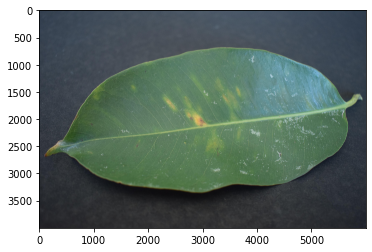

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

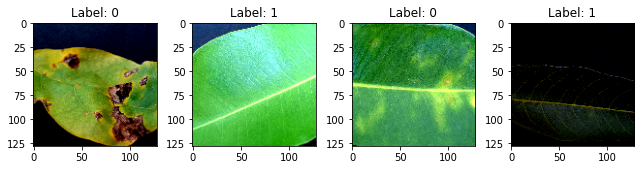

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:50] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:52] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2405059116809907 samples/sec                   batch loss = 0.889874279499054 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.2579693171009867 samples/sec                   batch loss = 0.8343273997306824 | accuracy = 0.475


Epoch[1] Batch[15] Speed: 1.2137282274883876 samples/sec                   batch loss = 0.7045453190803528 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.2528984431983248 samples/sec                   batch loss = 0.6363475918769836 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.261510353658224 samples/sec                   batch loss = 0.4052048921585083 | accuracy = 0.54


Epoch[1] Batch[30] Speed: 1.2534568987692492 samples/sec                   batch loss = 0.8128200769424438 | accuracy = 0.5583333333333333


Epoch[1] Batch[35] Speed: 1.2606303310951052 samples/sec                   batch loss = 1.5611042976379395 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.26413637698673 samples/sec                   batch loss = 0.9949408769607544 | accuracy = 0.55


Epoch[1] Batch[45] Speed: 1.2638496423231784 samples/sec                   batch loss = 0.4329131543636322 | accuracy = 0.5722222222222222


Epoch[1] Batch[50] Speed: 1.2585409889227765 samples/sec                   batch loss = 0.3265714645385742 | accuracy = 0.565


Epoch[1] Batch[55] Speed: 1.26340403821716 samples/sec                   batch loss = 0.3833732008934021 | accuracy = 0.5818181818181818


Epoch[1] Batch[60] Speed: 1.2595741077180636 samples/sec                   batch loss = 0.6325607895851135 | accuracy = 0.6


Epoch[1] Batch[65] Speed: 1.2564961068369673 samples/sec                   batch loss = 0.2178904265165329 | accuracy = 0.6115384615384616


Epoch[1] Batch[70] Speed: 1.263135323967415 samples/sec                   batch loss = 0.8827434778213501 | accuracy = 0.6035714285714285


Epoch[1] Batch[75] Speed: 1.2665657372900025 samples/sec                   batch loss = 0.29180318117141724 | accuracy = 0.61


Epoch[1] Batch[80] Speed: 1.2606178277783935 samples/sec                   batch loss = 1.3771522045135498 | accuracy = 0.609375


Epoch[1] Batch[85] Speed: 1.2628599748168925 samples/sec                   batch loss = 0.8470506072044373 | accuracy = 0.611764705882353


Epoch[1] Batch[90] Speed: 1.2666566756824604 samples/sec                   batch loss = 0.9209177494049072 | accuracy = 0.6111111111111112


Epoch[1] Batch[95] Speed: 1.2677638043698713 samples/sec                   batch loss = 0.3668160140514374 | accuracy = 0.6131578947368421


Epoch[1] Batch[100] Speed: 1.2696546087482972 samples/sec                   batch loss = 0.36166608333587646 | accuracy = 0.6175


Epoch[1] Batch[105] Speed: 1.2618500271779005 samples/sec                   batch loss = 0.4994388222694397 | accuracy = 0.6214285714285714


Epoch[1] Batch[110] Speed: 1.2629647378642297 samples/sec                   batch loss = 1.1800875663757324 | accuracy = 0.6227272727272727


Epoch[1] Batch[115] Speed: 1.2575667786571545 samples/sec                   batch loss = 0.5518485903739929 | accuracy = 0.6217391304347826


Epoch[1] Batch[120] Speed: 1.260683946613574 samples/sec                   batch loss = 0.41332682967185974 | accuracy = 0.6208333333333333


Epoch[1] Batch[125] Speed: 1.256677374915134 samples/sec                   batch loss = 0.7573502063751221 | accuracy = 0.624


Epoch[1] Batch[130] Speed: 1.2607409773115386 samples/sec                   batch loss = 0.4630745053291321 | accuracy = 0.6288461538461538


Epoch[1] Batch[135] Speed: 1.25378063014949 samples/sec                   batch loss = 0.6281907558441162 | accuracy = 0.6296296296296297


Epoch[1] Batch[140] Speed: 1.2572264863193983 samples/sec                   batch loss = 0.7423930168151855 | accuracy = 0.6375


Epoch[1] Batch[145] Speed: 1.2585390063303465 samples/sec                   batch loss = 0.36387836933135986 | accuracy = 0.6396551724137931


Epoch[1] Batch[150] Speed: 1.260101903430134 samples/sec                   batch loss = 0.7443085312843323 | accuracy = 0.6333333333333333


Epoch[1] Batch[155] Speed: 1.2566372768480765 samples/sec                   batch loss = 0.5484527945518494 | accuracy = 0.6370967741935484


Epoch[1] Batch[160] Speed: 1.2597522922023034 samples/sec                   batch loss = 1.0095487833023071 | accuracy = 0.6328125


Epoch[1] Batch[165] Speed: 1.257158186184701 samples/sec                   batch loss = 0.5277882218360901 | accuracy = 0.6318181818181818


Epoch[1] Batch[170] Speed: 1.2563932609302073 samples/sec                   batch loss = 0.271315336227417 | accuracy = 0.6308823529411764


Epoch[1] Batch[175] Speed: 1.258820408099565 samples/sec                   batch loss = 0.9368588328361511 | accuracy = 0.6342857142857142


Epoch[1] Batch[180] Speed: 1.2552600607682598 samples/sec                   batch loss = 0.8185446262359619 | accuracy = 0.6305555555555555


Epoch[1] Batch[185] Speed: 1.2604540761720073 samples/sec                   batch loss = 0.6743471026420593 | accuracy = 0.6324324324324324


Epoch[1] Batch[190] Speed: 1.2621693731702373 samples/sec                   batch loss = 0.7769491076469421 | accuracy = 0.6302631578947369


Epoch[1] Batch[195] Speed: 1.2659025976059304 samples/sec                   batch loss = 0.30147406458854675 | accuracy = 0.6333333333333333


Epoch[1] Batch[200] Speed: 1.2608156365879672 samples/sec                   batch loss = 0.5539212822914124 | accuracy = 0.635


Epoch[1] Batch[205] Speed: 1.260588749054026 samples/sec                   batch loss = 0.519005298614502 | accuracy = 0.6353658536585366


Epoch[1] Batch[210] Speed: 1.2662207491640463 samples/sec                   batch loss = 0.9331024289131165 | accuracy = 0.6369047619047619


Epoch[1] Batch[215] Speed: 1.2610487668647223 samples/sec                   batch loss = 0.22173689305782318 | accuracy = 0.641860465116279


Epoch[1] Batch[220] Speed: 1.2586993332588092 samples/sec                   batch loss = 0.359885036945343 | accuracy = 0.6431818181818182


Epoch[1] Batch[225] Speed: 1.262170322715576 samples/sec                   batch loss = 0.2989921271800995 | accuracy = 0.6455555555555555


Epoch[1] Batch[230] Speed: 1.2530290730818658 samples/sec                   batch loss = 0.8532313108444214 | accuracy = 0.6423913043478261


Epoch[1] Batch[235] Speed: 1.2569993817353906 samples/sec                   batch loss = 0.5653735995292664 | accuracy = 0.6446808510638298


Epoch[1] Batch[240] Speed: 1.2557955261559821 samples/sec                   batch loss = 0.5145944952964783 | accuracy = 0.6479166666666667


Epoch[1] Batch[245] Speed: 1.260112598252329 samples/sec                   batch loss = 0.4762061834335327 | accuracy = 0.6479591836734694


Epoch[1] Batch[250] Speed: 1.263744446849824 samples/sec                   batch loss = 0.28999343514442444 | accuracy = 0.65


Epoch[1] Batch[255] Speed: 1.255408562244588 samples/sec                   batch loss = 0.6675305366516113 | accuracy = 0.6519607843137255


Epoch[1] Batch[260] Speed: 1.2557836825373017 samples/sec                   batch loss = 0.9439451694488525 | accuracy = 0.6519230769230769


Epoch[1] Batch[265] Speed: 1.2622025131477421 samples/sec                   batch loss = 0.6241232752799988 | accuracy = 0.6509433962264151


Epoch[1] Batch[270] Speed: 1.2622547430057753 samples/sec                   batch loss = 0.6810408234596252 | accuracy = 0.6518518518518519


Epoch[1] Batch[275] Speed: 1.2611753187777468 samples/sec                   batch loss = 1.1978038549423218 | accuracy = 0.6518181818181819


Epoch[1] Batch[280] Speed: 1.2611681136424355 samples/sec                   batch loss = 0.9790537357330322 | accuracy = 0.6535714285714286


Epoch[1] Batch[285] Speed: 1.2619145668436422 samples/sec                   batch loss = 0.7400593757629395 | accuracy = 0.6578947368421053


Epoch[1] Batch[290] Speed: 1.2670556775326287 samples/sec                   batch loss = 0.538607120513916 | accuracy = 0.6586206896551724


Epoch[1] Batch[295] Speed: 1.2634666436523951 samples/sec                   batch loss = 0.6340330243110657 | accuracy = 0.6559322033898305


Epoch[1] Batch[300] Speed: 1.2599587238720766 samples/sec                   batch loss = 0.4652838408946991 | accuracy = 0.6583333333333333


Epoch[1] Batch[305] Speed: 1.2626379574322564 samples/sec                   batch loss = 0.3404043912887573 | accuracy = 0.660655737704918


Epoch[1] Batch[310] Speed: 1.2689590532448425 samples/sec                   batch loss = 0.5772556066513062 | accuracy = 0.6620967741935484


Epoch[1] Batch[315] Speed: 1.2590942818102957 samples/sec                   batch loss = 0.46052056550979614 | accuracy = 0.6603174603174603


Epoch[1] Batch[320] Speed: 1.2622255887156664 samples/sec                   batch loss = 0.9598686695098877 | accuracy = 0.65859375


Epoch[1] Batch[325] Speed: 1.2712013300275604 samples/sec                   batch loss = 0.30060094594955444 | accuracy = 0.6615384615384615


Epoch[1] Batch[330] Speed: 1.2697491624925 samples/sec                   batch loss = 0.44531434774398804 | accuracy = 0.6613636363636364


Epoch[1] Batch[335] Speed: 1.261436560527762 samples/sec                   batch loss = 0.491859495639801 | accuracy = 0.6619402985074627


Epoch[1] Batch[340] Speed: 1.2558772156100153 samples/sec                   batch loss = 0.5836377143859863 | accuracy = 0.6610294117647059


Epoch[1] Batch[345] Speed: 1.2557925182316616 samples/sec                   batch loss = 0.5264831781387329 | accuracy = 0.6615942028985508


Epoch[1] Batch[350] Speed: 1.2564057746742352 samples/sec                   batch loss = 0.9279873967170715 | accuracy = 0.6614285714285715


Epoch[1] Batch[355] Speed: 1.2545038215999942 samples/sec                   batch loss = 0.5634158849716187 | accuracy = 0.6619718309859155


Epoch[1] Batch[360] Speed: 1.260496880466284 samples/sec                   batch loss = 0.7029911875724792 | accuracy = 0.6631944444444444


Epoch[1] Batch[365] Speed: 1.259064989866147 samples/sec                   batch loss = 0.6055237650871277 | accuracy = 0.665068493150685


Epoch[1] Batch[370] Speed: 1.2565352548081683 samples/sec                   batch loss = 0.7683535814285278 | accuracy = 0.6648648648648648


Epoch[1] Batch[375] Speed: 1.2596847577553858 samples/sec                   batch loss = 0.7231615781784058 | accuracy = 0.6646666666666666


Epoch[1] Batch[380] Speed: 1.2582150779877816 samples/sec                   batch loss = 0.7960354089736938 | accuracy = 0.6631578947368421


Epoch[1] Batch[385] Speed: 1.260405404024711 samples/sec                   batch loss = 0.44531741738319397 | accuracy = 0.662987012987013


Epoch[1] Batch[390] Speed: 1.2548208674090935 samples/sec                   batch loss = 0.5115235447883606 | accuracy = 0.6621794871794872


Epoch[1] Batch[395] Speed: 1.2596842848506162 samples/sec                   batch loss = 0.4828415811061859 | accuracy = 0.6626582278481012


Epoch[1] Batch[400] Speed: 1.255775316941274 samples/sec                   batch loss = 0.5807655453681946 | accuracy = 0.663125


Epoch[1] Batch[405] Speed: 1.2554953687507133 samples/sec                   batch loss = 0.42462682723999023 | accuracy = 0.6623456790123456


Epoch[1] Batch[410] Speed: 1.2581033651675806 samples/sec                   batch loss = 0.33332109451293945 | accuracy = 0.6640243902439025


Epoch[1] Batch[415] Speed: 1.260966213725798 samples/sec                   batch loss = 0.5890400409698486 | accuracy = 0.6650602409638554


Epoch[1] Batch[420] Speed: 1.255201834484874 samples/sec                   batch loss = 0.9911128282546997 | accuracy = 0.6648809523809524


Epoch[1] Batch[425] Speed: 1.2593332037761344 samples/sec                   batch loss = 1.1916916370391846 | accuracy = 0.6641176470588235


Epoch[1] Batch[430] Speed: 1.2592791359641422 samples/sec                   batch loss = 0.40845778584480286 | accuracy = 0.6651162790697674


Epoch[1] Batch[435] Speed: 1.2582690544646413 samples/sec                   batch loss = 0.34522733092308044 | accuracy = 0.667816091954023


Epoch[1] Batch[440] Speed: 1.2525993883792048 samples/sec                   batch loss = 0.8869106769561768 | accuracy = 0.6670454545454545


Epoch[1] Batch[445] Speed: 1.2552957505153328 samples/sec                   batch loss = 0.6752640008926392 | accuracy = 0.6679775280898876


Epoch[1] Batch[450] Speed: 1.2551099981985658 samples/sec                   batch loss = 0.998803436756134 | accuracy = 0.6661111111111111


Epoch[1] Batch[455] Speed: 1.2587552401192699 samples/sec                   batch loss = 0.6465474367141724 | accuracy = 0.6659340659340659


Epoch[1] Batch[460] Speed: 1.2636963769205931 samples/sec                   batch loss = 0.56278395652771 | accuracy = 0.6673913043478261


Epoch[1] Batch[465] Speed: 1.2549240192446631 samples/sec                   batch loss = 0.3654034733772278 | accuracy = 0.667741935483871


Epoch[1] Batch[470] Speed: 1.260662253566508 samples/sec                   batch loss = 0.7460871338844299 | accuracy = 0.6686170212765957


Epoch[1] Batch[475] Speed: 1.2602421809202826 samples/sec                   batch loss = 0.6431224346160889 | accuracy = 0.6689473684210526


Epoch[1] Batch[480] Speed: 1.2628895386714953 samples/sec                   batch loss = 0.3650088310241699 | accuracy = 0.6703125


Epoch[1] Batch[485] Speed: 1.2604173349815135 samples/sec                   batch loss = 0.46959155797958374 | accuracy = 0.6706185567010309


Epoch[1] Batch[490] Speed: 1.2588938009901889 samples/sec                   batch loss = 1.3128770589828491 | accuracy = 0.6709183673469388


Epoch[1] Batch[495] Speed: 1.259530798723834 samples/sec                   batch loss = 0.7573423385620117 | accuracy = 0.6727272727272727


Epoch[1] Batch[500] Speed: 1.2564040810702326 samples/sec                   batch loss = 0.4357668161392212 | accuracy = 0.6725


Epoch[1] Batch[505] Speed: 1.2600666969793788 samples/sec                   batch loss = 0.529352068901062 | accuracy = 0.6742574257425743


Epoch[1] Batch[510] Speed: 1.2609203450113833 samples/sec                   batch loss = 1.4119175672531128 | accuracy = 0.6745098039215687


Epoch[1] Batch[515] Speed: 1.2629770025515916 samples/sec                   batch loss = 0.3676038086414337 | accuracy = 0.6757281553398058


Epoch[1] Batch[520] Speed: 1.2577445842037052 samples/sec                   batch loss = 1.951431155204773 | accuracy = 0.6754807692307693


Epoch[1] Batch[525] Speed: 1.251335619674648 samples/sec                   batch loss = 0.5897458791732788 | accuracy = 0.6747619047619048


Epoch[1] Batch[530] Speed: 1.2620595204190432 samples/sec                   batch loss = 1.1711461544036865 | accuracy = 0.6745283018867925


Epoch[1] Batch[535] Speed: 1.2584743394782525 samples/sec                   batch loss = 0.9211585521697998 | accuracy = 0.6742990654205607


Epoch[1] Batch[540] Speed: 1.2522661717677737 samples/sec                   batch loss = 0.656290590763092 | accuracy = 0.674074074074074


Epoch[1] Batch[545] Speed: 1.2567139925215356 samples/sec                   batch loss = 0.5652823448181152 | accuracy = 0.6752293577981652


Epoch[1] Batch[550] Speed: 1.261933265597842 samples/sec                   batch loss = 0.32251617312431335 | accuracy = 0.675


Epoch[1] Batch[555] Speed: 1.2573414357129984 samples/sec                   batch loss = 0.5918230414390564 | accuracy = 0.6756756756756757


Epoch[1] Batch[560] Speed: 1.2555744821037103 samples/sec                   batch loss = 0.5864269137382507 | accuracy = 0.6767857142857143


Epoch[1] Batch[565] Speed: 1.2616648919209967 samples/sec                   batch loss = 0.29249709844589233 | accuracy = 0.679646017699115


Epoch[1] Batch[570] Speed: 1.258455554295391 samples/sec                   batch loss = 0.35259220004081726 | accuracy = 0.6811403508771929


Epoch[1] Batch[575] Speed: 1.2572612515827035 samples/sec                   batch loss = 0.7686370015144348 | accuracy = 0.6826086956521739


Epoch[1] Batch[580] Speed: 1.2578395412667196 samples/sec                   batch loss = 1.0104172229766846 | accuracy = 0.6831896551724138


Epoch[1] Batch[585] Speed: 1.260017013803381 samples/sec                   batch loss = 0.29247596859931946 | accuracy = 0.6837606837606838


Epoch[1] Batch[590] Speed: 1.2649103811563125 samples/sec                   batch loss = 0.3282390832901001 | accuracy = 0.6838983050847458


Epoch[1] Batch[595] Speed: 1.26363070312683 samples/sec                   batch loss = 0.24187937378883362 | accuracy = 0.684453781512605


Epoch[1] Batch[600] Speed: 1.258200924083697 samples/sec                   batch loss = 0.43457379937171936 | accuracy = 0.6841666666666667


Epoch[1] Batch[605] Speed: 1.2688574198350635 samples/sec                   batch loss = 0.5195615291595459 | accuracy = 0.6847107438016529


Epoch[1] Batch[610] Speed: 1.2604731104660445 samples/sec                   batch loss = 0.3259355127811432 | accuracy = 0.6856557377049181


Epoch[1] Batch[615] Speed: 1.2568391109331833 samples/sec                   batch loss = 0.7339975237846375 | accuracy = 0.6845528455284553


Epoch[1] Batch[620] Speed: 1.2545170481863837 samples/sec                   batch loss = 0.47552525997161865 | accuracy = 0.6858870967741936


Epoch[1] Batch[625] Speed: 1.2636327017937523 samples/sec                   batch loss = 0.31476545333862305 | accuracy = 0.686


Epoch[1] Batch[630] Speed: 1.2620489823963095 samples/sec                   batch loss = 0.8293704986572266 | accuracy = 0.6853174603174603


Epoch[1] Batch[635] Speed: 1.2648864444097971 samples/sec                   batch loss = 0.6527246236801147 | accuracy = 0.6858267716535433


Epoch[1] Batch[640] Speed: 1.260546696203517 samples/sec                   batch loss = 0.47293365001678467 | accuracy = 0.68671875


Epoch[1] Batch[645] Speed: 1.2656002629988645 samples/sec                   batch loss = 0.7107046246528625 | accuracy = 0.6852713178294574


Epoch[1] Batch[650] Speed: 1.261753419840206 samples/sec                   batch loss = 0.31668728590011597 | accuracy = 0.6846153846153846


Epoch[1] Batch[655] Speed: 1.2575119198632607 samples/sec                   batch loss = 0.7549315094947815 | accuracy = 0.6854961832061068


Epoch[1] Batch[660] Speed: 1.263268287562754 samples/sec                   batch loss = 0.43715500831604004 | accuracy = 0.6859848484848485


Epoch[1] Batch[665] Speed: 1.2587792287069697 samples/sec                   batch loss = 0.6858786940574646 | accuracy = 0.6860902255639098


Epoch[1] Batch[670] Speed: 1.2589260134422782 samples/sec                   batch loss = 0.39689821004867554 | accuracy = 0.685820895522388


Epoch[1] Batch[675] Speed: 1.265508712564936 samples/sec                   batch loss = 0.26965877413749695 | accuracy = 0.687037037037037


Epoch[1] Batch[680] Speed: 1.2645316955307366 samples/sec                   batch loss = 0.2063198983669281 | accuracy = 0.6878676470588235


Epoch[1] Batch[685] Speed: 1.2694569946240395 samples/sec                   batch loss = 1.399641513824463 | accuracy = 0.6868613138686132


Epoch[1] Batch[690] Speed: 1.2621694681247069 samples/sec                   batch loss = 0.4801879823207855 | accuracy = 0.6865942028985508


Epoch[1] Batch[695] Speed: 1.2591325523714947 samples/sec                   batch loss = 0.4616941809654236 | accuracy = 0.6870503597122302


Epoch[1] Batch[700] Speed: 1.2504549116822155 samples/sec                   batch loss = 0.4515981674194336 | accuracy = 0.6860714285714286


Epoch[1] Batch[705] Speed: 1.2591136530381646 samples/sec                   batch loss = 0.46710121631622314 | accuracy = 0.6843971631205674


Epoch[1] Batch[710] Speed: 1.2570914005400395 samples/sec                   batch loss = 1.2123939990997314 | accuracy = 0.6841549295774648


Epoch[1] Batch[715] Speed: 1.2576973467552959 samples/sec                   batch loss = 0.419448584318161 | accuracy = 0.6846153846153846


Epoch[1] Batch[720] Speed: 1.2556213722761294 samples/sec                   batch loss = 0.39613035321235657 | accuracy = 0.6857638888888888


Epoch[1] Batch[725] Speed: 1.2554822154781446 samples/sec                   batch loss = 0.36439213156700134 | accuracy = 0.6865517241379311


Epoch[1] Batch[730] Speed: 1.2541777478226912 samples/sec                   batch loss = 0.5560728311538696 | accuracy = 0.686986301369863


Epoch[1] Batch[735] Speed: 1.2550219306218267 samples/sec                   batch loss = 0.2240411639213562 | accuracy = 0.6880952380952381


Epoch[1] Batch[740] Speed: 1.2605707531214072 samples/sec                   batch loss = 0.2828509509563446 | accuracy = 0.6898648648648649


Epoch[1] Batch[745] Speed: 1.259924944675761 samples/sec                   batch loss = 0.7045872807502747 | accuracy = 0.689261744966443


Epoch[1] Batch[750] Speed: 1.252070288770245 samples/sec                   batch loss = 0.3997703194618225 | accuracy = 0.6886666666666666


Epoch[1] Batch[755] Speed: 1.2535984170058594 samples/sec                   batch loss = 0.22489982843399048 | accuracy = 0.6900662251655629


Epoch[1] Batch[760] Speed: 1.2583181280079394 samples/sec                   batch loss = 0.6189139485359192 | accuracy = 0.6898026315789474


Epoch[1] Batch[765] Speed: 1.2537452138853429 samples/sec                   batch loss = 1.0188039541244507 | accuracy = 0.6901960784313725


Epoch[1] Batch[770] Speed: 1.2555597298078032 samples/sec                   batch loss = 0.5871323347091675 | accuracy = 0.6896103896103896


Epoch[1] Batch[775] Speed: 1.2555980677045804 samples/sec                   batch loss = 0.25125429034233093 | accuracy = 0.6903225806451613


Epoch[1] Batch[780] Speed: 1.25881918023467 samples/sec                   batch loss = 0.480318546295166 | accuracy = 0.6907051282051282


Epoch[1] Batch[785] Speed: 1.2574015569634094 samples/sec                   batch loss = 0.33620041608810425 | accuracy = 0.6914012738853503


[Epoch 1] training: accuracy=0.6916243654822335
[Epoch 1] time cost: 653.1087069511414
[Epoch 1] validation: validation accuracy=0.7722222222222223


Epoch[2] Batch[5] Speed: 1.2705378508171339 samples/sec                   batch loss = 0.936850368976593 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2662134862641719 samples/sec                   batch loss = 0.811608076095581 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2669095740869016 samples/sec                   batch loss = 0.9768581390380859 | accuracy = 0.6833333333333333


Epoch[2] Batch[20] Speed: 1.2687193434898643 samples/sec                   batch loss = 0.46617138385772705 | accuracy = 0.675


Epoch[2] Batch[25] Speed: 1.2644651724860685 samples/sec                   batch loss = 0.32798629999160767 | accuracy = 0.69


Epoch[2] Batch[30] Speed: 1.2678613343167564 samples/sec                   batch loss = 0.40779078006744385 | accuracy = 0.7083333333333334


Epoch[2] Batch[35] Speed: 1.2760472054568512 samples/sec                   batch loss = 0.6267841458320618 | accuracy = 0.7285714285714285


Epoch[2] Batch[40] Speed: 1.2685940549020356 samples/sec                   batch loss = 0.7878713011741638 | accuracy = 0.73125


Epoch[2] Batch[45] Speed: 1.264416666541058 samples/sec                   batch loss = 0.47863441705703735 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.2643174744180028 samples/sec                   batch loss = 0.47057056427001953 | accuracy = 0.75


Epoch[2] Batch[55] Speed: 1.2612465213175883 samples/sec                   batch loss = 0.852604329586029 | accuracy = 0.7272727272727273


Epoch[2] Batch[60] Speed: 1.2583919342743386 samples/sec                   batch loss = 0.18196037411689758 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.2613056890642214 samples/sec                   batch loss = 0.3115169405937195 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.2619046956435929 samples/sec                   batch loss = 0.4994474947452545 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.263218066262942 samples/sec                   batch loss = 0.5782970786094666 | accuracy = 0.7333333333333333


Epoch[2] Batch[80] Speed: 1.2655785913658735 samples/sec                   batch loss = 0.7528640627861023 | accuracy = 0.7375


Epoch[2] Batch[85] Speed: 1.2637416862994675 samples/sec                   batch loss = 1.3039005994796753 | accuracy = 0.7441176470588236


Epoch[2] Batch[90] Speed: 1.2608863247113629 samples/sec                   batch loss = 0.37318843603134155 | accuracy = 0.7472222222222222


Epoch[2] Batch[95] Speed: 1.262641663417346 samples/sec                   batch loss = 1.0834208726882935 | accuracy = 0.7368421052631579


Epoch[2] Batch[100] Speed: 1.2690979497716908 samples/sec                   batch loss = 0.10486330837011337 | accuracy = 0.7425


Epoch[2] Batch[105] Speed: 1.265681036944329 samples/sec                   batch loss = 0.49471670389175415 | accuracy = 0.7452380952380953


Epoch[2] Batch[110] Speed: 1.2623113460593625 samples/sec                   batch loss = 0.3051503896713257 | accuracy = 0.7431818181818182


Epoch[2] Batch[115] Speed: 1.25927951404461 samples/sec                   batch loss = 0.5758153200149536 | accuracy = 0.7456521739130435


Epoch[2] Batch[120] Speed: 1.2592615554731086 samples/sec                   batch loss = 0.227365180850029 | accuracy = 0.75


Epoch[2] Batch[125] Speed: 1.257416446813363 samples/sec                   batch loss = 0.3990553319454193 | accuracy = 0.754


Epoch[2] Batch[130] Speed: 1.2616310211800434 samples/sec                   batch loss = 0.7113567590713501 | accuracy = 0.7423076923076923


Epoch[2] Batch[135] Speed: 1.2623856215248537 samples/sec                   batch loss = 0.9033006429672241 | accuracy = 0.7333333333333333


Epoch[2] Batch[140] Speed: 1.2601203592104209 samples/sec                   batch loss = 0.20065836608409882 | accuracy = 0.7375


Epoch[2] Batch[145] Speed: 1.264483375087805 samples/sec                   batch loss = 0.052727166563272476 | accuracy = 0.7379310344827587


Epoch[2] Batch[150] Speed: 1.2712447710625772 samples/sec                   batch loss = 0.4513750970363617 | accuracy = 0.735


Epoch[2] Batch[155] Speed: 1.2653021760926204 samples/sec                   batch loss = 0.9543930888175964 | accuracy = 0.7387096774193549


Epoch[2] Batch[160] Speed: 1.2673583250326976 samples/sec                   batch loss = 0.2601497173309326 | accuracy = 0.7421875


Epoch[2] Batch[165] Speed: 1.2609573050779916 samples/sec                   batch loss = 0.0986226499080658 | accuracy = 0.7439393939393939


Epoch[2] Batch[170] Speed: 1.2623751730410637 samples/sec                   batch loss = 0.9602121114730835 | accuracy = 0.7411764705882353


Epoch[2] Batch[175] Speed: 1.261516139859938 samples/sec                   batch loss = 0.3735555112361908 | accuracy = 0.7442857142857143


Epoch[2] Batch[180] Speed: 1.257645870462719 samples/sec                   batch loss = 0.20614176988601685 | accuracy = 0.7458333333333333


Epoch[2] Batch[185] Speed: 1.261164700712338 samples/sec                   batch loss = 1.260516881942749 | accuracy = 0.7445945945945946


Epoch[2] Batch[190] Speed: 1.2600601669669007 samples/sec                   batch loss = 0.09930919855833054 | accuracy = 0.7486842105263158


Epoch[2] Batch[195] Speed: 1.2572587077177544 samples/sec                   batch loss = 0.43064752221107483 | accuracy = 0.7525641025641026


Epoch[2] Batch[200] Speed: 1.2649697024166364 samples/sec                   batch loss = 0.8102378845214844 | accuracy = 0.7525


Epoch[2] Batch[205] Speed: 1.2674611547081984 samples/sec                   batch loss = 0.48373109102249146 | accuracy = 0.7536585365853659


Epoch[2] Batch[210] Speed: 1.2613196284278554 samples/sec                   batch loss = 0.894839346408844 | accuracy = 0.7535714285714286


Epoch[2] Batch[215] Speed: 1.2660858257339855 samples/sec                   batch loss = 0.7917225360870361 | accuracy = 0.7523255813953489


Epoch[2] Batch[220] Speed: 1.2651707875622575 samples/sec                   batch loss = 0.1836758852005005 | accuracy = 0.7534090909090909


Epoch[2] Batch[225] Speed: 1.2654364553089907 samples/sec                   batch loss = 0.542212724685669 | accuracy = 0.7511111111111111


Epoch[2] Batch[230] Speed: 1.2631183013223761 samples/sec                   batch loss = 0.8716722130775452 | accuracy = 0.7478260869565218


Epoch[2] Batch[235] Speed: 1.2647559049514665 samples/sec                   batch loss = 0.24651965498924255 | accuracy = 0.747872340425532


Epoch[2] Batch[240] Speed: 1.2616819702951683 samples/sec                   batch loss = 0.5378975868225098 | accuracy = 0.7458333333333333


Epoch[2] Batch[245] Speed: 1.257859534054401 samples/sec                   batch loss = 0.5853121280670166 | accuracy = 0.7459183673469387


Epoch[2] Batch[250] Speed: 1.2610219430176046 samples/sec                   batch loss = 0.47505924105644226 | accuracy = 0.744


Epoch[2] Batch[255] Speed: 1.2591305679148361 samples/sec                   batch loss = 0.9729824066162109 | accuracy = 0.7441176470588236


Epoch[2] Batch[260] Speed: 1.2722360521439446 samples/sec                   batch loss = 0.4363251328468323 | accuracy = 0.7442307692307693


Epoch[2] Batch[265] Speed: 1.2634302023480506 samples/sec                   batch loss = 0.41288265585899353 | accuracy = 0.7433962264150943


Epoch[2] Batch[270] Speed: 1.2643500603152853 samples/sec                   batch loss = 0.250872939825058 | accuracy = 0.7416666666666667


Epoch[2] Batch[275] Speed: 1.2608650037321183 samples/sec                   batch loss = 0.192631334066391 | accuracy = 0.7445454545454545


Epoch[2] Batch[280] Speed: 1.2633258377115941 samples/sec                   batch loss = 0.4313804805278778 | accuracy = 0.74375


Epoch[2] Batch[285] Speed: 1.2573879867744002 samples/sec                   batch loss = 0.39648333191871643 | accuracy = 0.7429824561403509


Epoch[2] Batch[290] Speed: 1.2625116818640956 samples/sec                   batch loss = 0.6242313981056213 | accuracy = 0.7456896551724138


Epoch[2] Batch[295] Speed: 1.2641645718088526 samples/sec                   batch loss = 0.519044041633606 | accuracy = 0.7466101694915255


Epoch[2] Batch[300] Speed: 1.2567935419757046 samples/sec                   batch loss = 0.5921807289123535 | accuracy = 0.75


Epoch[2] Batch[305] Speed: 1.260936266005199 samples/sec                   batch loss = 1.015017032623291 | accuracy = 0.7483606557377049


Epoch[2] Batch[310] Speed: 1.259090313144495 samples/sec                   batch loss = 0.28988635540008545 | accuracy = 0.7483870967741936


Epoch[2] Batch[315] Speed: 1.255741949661541 samples/sec                   batch loss = 0.42012980580329895 | accuracy = 0.7484126984126984


Epoch[2] Batch[320] Speed: 1.2578702851558297 samples/sec                   batch loss = 0.2853591740131378 | accuracy = 0.75


Epoch[2] Batch[325] Speed: 1.2590284240937282 samples/sec                   batch loss = 0.43460381031036377 | accuracy = 0.7484615384615385


Epoch[2] Batch[330] Speed: 1.2698018265777447 samples/sec                   batch loss = 0.323180228471756 | accuracy = 0.7484848484848485


Epoch[2] Batch[335] Speed: 1.269727156349557 samples/sec                   batch loss = 0.41997700929641724 | accuracy = 0.7492537313432835


Epoch[2] Batch[340] Speed: 1.263096048947598 samples/sec                   batch loss = 0.2592681050300598 | accuracy = 0.75


Epoch[2] Batch[345] Speed: 1.2665034936158914 samples/sec                   batch loss = 0.39794784784317017 | accuracy = 0.7514492753623189


Epoch[2] Batch[350] Speed: 1.2618828656534378 samples/sec                   batch loss = 0.46528342366218567 | accuracy = 0.7521428571428571


Epoch[2] Batch[355] Speed: 1.2628802225808087 samples/sec                   batch loss = 0.6595975756645203 | accuracy = 0.752112676056338


Epoch[2] Batch[360] Speed: 1.2600718074711375 samples/sec                   batch loss = 0.2555440366268158 | accuracy = 0.7534722222222222


Epoch[2] Batch[365] Speed: 1.255535018139804 samples/sec                   batch loss = 0.6590546369552612 | accuracy = 0.7534246575342466


Epoch[2] Batch[370] Speed: 1.2565584059581836 samples/sec                   batch loss = 0.26375138759613037 | accuracy = 0.7513513513513513


Epoch[2] Batch[375] Speed: 1.2646438856306887 samples/sec                   batch loss = 0.2373802214860916 | accuracy = 0.752


Epoch[2] Batch[380] Speed: 1.2678662207893678 samples/sec                   batch loss = 0.7429246306419373 | accuracy = 0.7526315789473684


Epoch[2] Batch[385] Speed: 1.2639478088262304 samples/sec                   batch loss = 0.4363727271556854 | accuracy = 0.7532467532467533


Epoch[2] Batch[390] Speed: 1.2628528454771113 samples/sec                   batch loss = 0.43171992897987366 | accuracy = 0.7538461538461538


Epoch[2] Batch[395] Speed: 1.2650690923025567 samples/sec                   batch loss = 0.40535733103752136 | accuracy = 0.7537974683544304


Epoch[2] Batch[400] Speed: 1.269203462338232 samples/sec                   batch loss = 0.9602680802345276 | accuracy = 0.753125


Epoch[2] Batch[405] Speed: 1.2617932756918508 samples/sec                   batch loss = 0.3065199553966522 | accuracy = 0.7537037037037037


Epoch[2] Batch[410] Speed: 1.259981149717058 samples/sec                   batch loss = 0.18648655712604523 | accuracy = 0.7530487804878049


Epoch[2] Batch[415] Speed: 1.2618389232245921 samples/sec                   batch loss = 0.44496461749076843 | accuracy = 0.7530120481927711


Epoch[2] Batch[420] Speed: 1.256860766761349 samples/sec                   batch loss = 0.4358241856098175 | accuracy = 0.7529761904761905


Epoch[2] Batch[425] Speed: 1.2573849712166199 samples/sec                   batch loss = 0.6409230828285217 | accuracy = 0.7505882352941177


Epoch[2] Batch[430] Speed: 1.2588369372832358 samples/sec                   batch loss = 0.3919072449207306 | accuracy = 0.7517441860465116


Epoch[2] Batch[435] Speed: 1.2566560077862683 samples/sec                   batch loss = 0.5919985771179199 | accuracy = 0.7522988505747127


Epoch[2] Batch[440] Speed: 1.266203547694097 samples/sec                   batch loss = 1.2243539094924927 | accuracy = 0.7539772727272728


Epoch[2] Batch[445] Speed: 1.2611012804557074 samples/sec                   batch loss = 0.7100571393966675 | accuracy = 0.7539325842696629


Epoch[2] Batch[450] Speed: 1.2655359185577737 samples/sec                   batch loss = 1.1020634174346924 | accuracy = 0.7538888888888889


Epoch[2] Batch[455] Speed: 1.2568203745361897 samples/sec                   batch loss = 0.5712705850601196 | accuracy = 0.7543956043956044


Epoch[2] Batch[460] Speed: 1.2575020231678105 samples/sec                   batch loss = 0.5240621566772461 | accuracy = 0.7548913043478261


Epoch[2] Batch[465] Speed: 1.2579081040869002 samples/sec                   batch loss = 0.43925613164901733 | accuracy = 0.7548387096774194


Epoch[2] Batch[470] Speed: 1.2549331244522781 samples/sec                   batch loss = 0.3918783962726593 | accuracy = 0.7553191489361702


Epoch[2] Batch[475] Speed: 1.250472153930492 samples/sec                   batch loss = 0.39853712916374207 | accuracy = 0.7552631578947369


Epoch[2] Batch[480] Speed: 1.254560857382637 samples/sec                   batch loss = 0.1951315551996231 | accuracy = 0.7552083333333334


Epoch[2] Batch[485] Speed: 1.2497046356614496 samples/sec                   batch loss = 0.6266831159591675 | accuracy = 0.7546391752577319


Epoch[2] Batch[490] Speed: 1.25406759439714 samples/sec                   batch loss = 0.37880292534828186 | accuracy = 0.7551020408163265


Epoch[2] Batch[495] Speed: 1.252996974533353 samples/sec                   batch loss = 0.4398479759693146 | accuracy = 0.7545454545454545


Epoch[2] Batch[500] Speed: 1.2547167003282698 samples/sec                   batch loss = 0.38767585158348083 | accuracy = 0.7545


Epoch[2] Batch[505] Speed: 1.2516516262010724 samples/sec                   batch loss = 0.28061768412590027 | accuracy = 0.754950495049505


Epoch[2] Batch[510] Speed: 1.2573458645117668 samples/sec                   batch loss = 0.3129964768886566 | accuracy = 0.7558823529411764


Epoch[2] Batch[515] Speed: 1.25691895872681 samples/sec                   batch loss = 0.22223898768424988 | accuracy = 0.7567961165048543


Epoch[2] Batch[520] Speed: 1.2542970165804013 samples/sec                   batch loss = 0.2840990424156189 | accuracy = 0.7557692307692307


Epoch[2] Batch[525] Speed: 1.2534001505973353 samples/sec                   batch loss = 0.38856860995292664 | accuracy = 0.7557142857142857


Epoch[2] Batch[530] Speed: 1.2561705956090226 samples/sec                   batch loss = 0.37198391556739807 | accuracy = 0.755188679245283


Epoch[2] Batch[535] Speed: 1.2534974497031004 samples/sec                   batch loss = 0.7018788456916809 | accuracy = 0.7532710280373832


Epoch[2] Batch[540] Speed: 1.2533897566869876 samples/sec                   batch loss = 0.20424006879329681 | accuracy = 0.7541666666666667


Epoch[2] Batch[545] Speed: 1.2551958243373929 samples/sec                   batch loss = 0.35336238145828247 | accuracy = 0.7545871559633027


Epoch[2] Batch[550] Speed: 1.2601659804332401 samples/sec                   batch loss = 0.19561301171779633 | accuracy = 0.7545454545454545


Epoch[2] Batch[555] Speed: 1.2538933571338566 samples/sec                   batch loss = 0.2861552834510803 | accuracy = 0.7549549549549549


Epoch[2] Batch[560] Speed: 1.2633819660476397 samples/sec                   batch loss = 0.9867551922798157 | accuracy = 0.7549107142857143


Epoch[2] Batch[565] Speed: 1.2666742720000943 samples/sec                   batch loss = 0.30847910046577454 | accuracy = 0.7553097345132743


Epoch[2] Batch[570] Speed: 1.2565457950633672 samples/sec                   batch loss = 0.48148858547210693 | accuracy = 0.756578947368421


Epoch[2] Batch[575] Speed: 1.2572174420132125 samples/sec                   batch loss = 0.5422109365463257 | accuracy = 0.7565217391304347


Epoch[2] Batch[580] Speed: 1.2576022226223365 samples/sec                   batch loss = 0.6563385128974915 | accuracy = 0.7564655172413793


Epoch[2] Batch[585] Speed: 1.2574687525623867 samples/sec                   batch loss = 0.2937789559364319 | accuracy = 0.7572649572649572


Epoch[2] Batch[590] Speed: 1.2587879177123293 samples/sec                   batch loss = 0.5722594261169434 | accuracy = 0.7567796610169492


Epoch[2] Batch[595] Speed: 1.2611071577001076 samples/sec                   batch loss = 0.33072859048843384 | accuracy = 0.7558823529411764


Epoch[2] Batch[600] Speed: 1.263009329225488 samples/sec                   batch loss = 0.2949129343032837 | accuracy = 0.7554166666666666


Epoch[2] Batch[605] Speed: 1.2645020547422776 samples/sec                   batch loss = 0.2726088762283325 | accuracy = 0.756198347107438


Epoch[2] Batch[610] Speed: 1.2625605168236262 samples/sec                   batch loss = 0.1264994740486145 | accuracy = 0.7569672131147541


Epoch[2] Batch[615] Speed: 1.2666036027942378 samples/sec                   batch loss = 1.7156004905700684 | accuracy = 0.7573170731707317


Epoch[2] Batch[620] Speed: 1.265970131729525 samples/sec                   batch loss = 0.9538569450378418 | accuracy = 0.7576612903225807


Epoch[2] Batch[625] Speed: 1.250083247155421 samples/sec                   batch loss = 0.41656091809272766 | accuracy = 0.7576


Epoch[2] Batch[630] Speed: 1.262218181651299 samples/sec                   batch loss = 0.24785658717155457 | accuracy = 0.7583333333333333


Epoch[2] Batch[635] Speed: 1.262462280690731 samples/sec                   batch loss = 0.9830389022827148 | accuracy = 0.7582677165354331


Epoch[2] Batch[640] Speed: 1.2652773657109044 samples/sec                   batch loss = 0.5353509187698364 | accuracy = 0.75859375


Epoch[2] Batch[645] Speed: 1.2707589015034026 samples/sec                   batch loss = 0.7652814984321594 | accuracy = 0.7581395348837209


Epoch[2] Batch[650] Speed: 1.2585785649508423 samples/sec                   batch loss = 0.28039664030075073 | accuracy = 0.7592307692307693


Epoch[2] Batch[655] Speed: 1.2590580922840102 samples/sec                   batch loss = 0.38983383774757385 | accuracy = 0.7599236641221374


Epoch[2] Batch[660] Speed: 1.2577728717995313 samples/sec                   batch loss = 0.4392780363559723 | accuracy = 0.7606060606060606


Epoch[2] Batch[665] Speed: 1.2585057752346775 samples/sec                   batch loss = 1.119386076927185 | accuracy = 0.7616541353383459


Epoch[2] Batch[670] Speed: 1.2621482936316308 samples/sec                   batch loss = 0.5855727195739746 | accuracy = 0.7623134328358209


Epoch[2] Batch[675] Speed: 1.262155984733052 samples/sec                   batch loss = 0.5165618658065796 | accuracy = 0.7611111111111111


Epoch[2] Batch[680] Speed: 1.2643368161368809 samples/sec                   batch loss = 0.41341912746429443 | accuracy = 0.7610294117647058


Epoch[2] Batch[685] Speed: 1.2618704323879468 samples/sec                   batch loss = 0.5465817451477051 | accuracy = 0.7602189781021897


Epoch[2] Batch[690] Speed: 1.2666446263121818 samples/sec                   batch loss = 0.7063616514205933 | accuracy = 0.7608695652173914


Epoch[2] Batch[695] Speed: 1.2592440699877598 samples/sec                   batch loss = 0.24797306954860687 | accuracy = 0.760431654676259


Epoch[2] Batch[700] Speed: 1.262210869634563 samples/sec                   batch loss = 0.4165968894958496 | accuracy = 0.76


Epoch[2] Batch[705] Speed: 1.2629310825040114 samples/sec                   batch loss = 0.47821417450904846 | accuracy = 0.7599290780141844


Epoch[2] Batch[710] Speed: 1.2649148634366427 samples/sec                   batch loss = 0.6292946338653564 | accuracy = 0.7595070422535212


Epoch[2] Batch[715] Speed: 1.2644586921051448 samples/sec                   batch loss = 0.9548376798629761 | accuracy = 0.7604895104895105


Epoch[2] Batch[720] Speed: 1.2628980943860586 samples/sec                   batch loss = 0.18121473491191864 | accuracy = 0.7604166666666666


Epoch[2] Batch[725] Speed: 1.2599066838476967 samples/sec                   batch loss = 0.4255076050758362 | accuracy = 0.76


Epoch[2] Batch[730] Speed: 1.2593754593016857 samples/sec                   batch loss = 0.21665844321250916 | accuracy = 0.7592465753424658


Epoch[2] Batch[735] Speed: 1.2509930939389244 samples/sec                   batch loss = 0.4893856644630432 | accuracy = 0.7598639455782313


Epoch[2] Batch[740] Speed: 1.2593889778873 samples/sec                   batch loss = 0.2896122336387634 | accuracy = 0.7597972972972973


Epoch[2] Batch[745] Speed: 1.2644972894718634 samples/sec                   batch loss = 0.2531796097755432 | accuracy = 0.7607382550335571


Epoch[2] Batch[750] Speed: 1.26333192596791 samples/sec                   batch loss = 1.5158920288085938 | accuracy = 0.7606666666666667


Epoch[2] Batch[755] Speed: 1.2607718631987332 samples/sec                   batch loss = 0.47180259227752686 | accuracy = 0.7605960264900662


Epoch[2] Batch[760] Speed: 1.2586292678213369 samples/sec                   batch loss = 0.2624915838241577 | accuracy = 0.7618421052631579


Epoch[2] Batch[765] Speed: 1.2658007846701933 samples/sec                   batch loss = 0.49595415592193604 | accuracy = 0.7620915032679738


Epoch[2] Batch[770] Speed: 1.2608902099452497 samples/sec                   batch loss = 0.3416474461555481 | accuracy = 0.7626623376623377


Epoch[2] Batch[775] Speed: 1.2646880236407756 samples/sec                   batch loss = 0.9531603455543518 | accuracy = 0.7612903225806451


Epoch[2] Batch[780] Speed: 1.2573220247502719 samples/sec                   batch loss = 0.1741134226322174 | accuracy = 0.7621794871794871


Epoch[2] Batch[785] Speed: 1.2624302669948828 samples/sec                   batch loss = 0.697083592414856 | accuracy = 0.7614649681528662


[Epoch 2] training: accuracy=0.761738578680203
[Epoch 2] time cost: 642.3000402450562
[Epoch 2] validation: validation accuracy=0.7755555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7822222222222223

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)